In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):
    bonos = 'SELECT TOP(' + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt, bono.Nemotecnico AS Nemotecnico FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo WHERE bono.Nemotecnico = riesgo.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(2,cn))
bonos

,Moneda,TablaDesarrollo,Base1,Base2,FechaEmision,RiesgoInt,Nemotecnico,Convencion,Riesgo
0,UF,"1#01-06-2018#1,9068#9,09092#90,90908#10,99772|...",ACT,365,2017-12-01,3,BAARA-A,ACT/365,AA
1,UF,"1#01-06-2018#1,9068#9,09092#90,90908#10,99772|...",ACT,365,2017-12-01,3,BAARA-A,ACT/365,AA


In [8]:
'''derivados = derivados_dBDerivados(5, cn)
derivados["Derivado"][1].genera_flujos()
derivados["Derivado"][1].valoriza_flujos()
derivados["Derivado"][1].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]'''

'derivados = derivados_dBDerivados(5, cn)\nderivados["Derivado"][1].genera_flujos()\nderivados["Derivado"][1].valoriza_flujos()\nderivados["Derivado"][1].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]'

In [7]:
acciones = historico("DE000DWS2D90", "A", 60)


Nivel1           Nivel2
0  Renta Variable Extranjera  Equities Europe DE000DWS2D90
Renta Variable Extranjera Equities Europe
                 Nivel1             Nivel2
0  Renta Fija Nacional   Bonos Financieros BAARA-A
Renta Fija Nacional  Bonos Financieros
                 Nivel1             Nivel2
0  Renta Fija Nacional   Bonos Financieros BAARA-A
Renta Fija Nacional  Bonos Financieros
{'Renta Variable Extranjera': [<Accion.Accion object at 0x000001A664DD6B48>], 'Renta Fija Nacional ': [<Bono.Bono object at 0x000001A664DDD988>, <Bono.Bono object at 0x000001A664E1B4C8>]} {'Equities Europe': [<Accion.Accion object at 0x000001A664DD6B48>], 'Bonos Financieros': [<Bono.Bono object at 0x000001A664DDD988>, <Bono.Bono object at 0x000001A664E1B4C8>]}


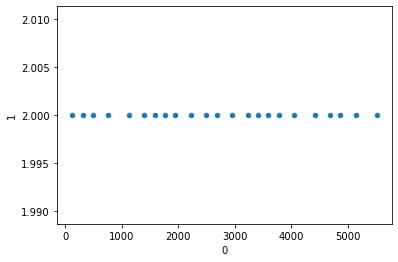

In [9]:
cartera = Cartera(acciones, bonos, pd.DataFrame(),'CLP', datetime.date(2019,2,1), cn, 60)

In [10]:
print(cartera.get_historicos_totales())

UF#119#AA  UF#299#AA  UF#480#AA  UF#750#AA  UF#1110#AA  UF#1380#AA  \
0    1.018654   1.047534   1.077400   1.123541    1.188150    1.239034   
1    1.018712   1.047684   1.077648   1.123945    1.188780    1.239809   
2    1.018747   1.047774   1.077796   1.124187    1.189150    1.240251   
3    1.018304   1.046629   1.075921   1.121184    1.184422    1.234028   
4    1.018243   1.046471   1.075646   1.120670    1.183438    1.232980   
5    1.018205   1.046374   1.075443   1.120205    1.182772    1.232043   
6    1.018058   1.045995   1.074861   1.119409    1.181737    1.230704   
7    1.017833   1.045413   1.073916   1.117923    1.179342    1.227566   
8    1.018071   1.046028   1.074914   1.119494    1.181822    1.230835   
9    1.018082   1.046057   1.074962   1.119572    1.175547    1.152534   
10   0.996159   0.987564   0.974349   0.944515    0.919040    0.900284   
11   0.995432   0.980851   0.963811   0.944087    0.918266    0.899347   
12   0.995513   0.981679   0.965604   0.94

In [11]:
print(cartera.get_retornos_totales())

UF#119#AA  UF#299#AA  UF#480#AA  UF#750#AA  UF#1110#AA  UF#1380#AA  \
0   0.000000e+00   0.000000   0.000000   0.000000    0.000000    0.000000   
1   1.537798e-04   0.000240   0.000327   0.000457    0.000626    0.000722   
2   1.308385e-04   0.000183   0.000234   0.000312    0.000408    0.000453   
3  -3.386966e-04  -0.000997  -0.001644  -0.002578   -0.003887   -0.004934   
4   2.297592e-04   0.000139   0.000033  -0.000168   -0.000542   -0.000560   
5   5.974034e-05   0.000004  -0.000092  -0.000319   -0.000466   -0.000664   
6  -4.747648e-05  -0.000265  -0.000445  -0.000614   -0.000779   -0.000990   
7  -1.251324e-04  -0.000461  -0.000782  -0.001232   -0.001932   -0.002457   
8   3.307539e-04   0.000685   0.001025   0.001501    0.002197    0.002756   
9   3.011275e-04   0.000318   0.000335   0.000360   -0.005034   -0.065440   
10 -2.167233e-02  -0.057445  -0.098175  -0.169933   -0.246063   -0.246911   
11 -6.334724e-04  -0.006724  -0.010778  -0.000357   -0.000745   -0.000945   
12  1.

In [12]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.0035103985364756483
